In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [2]:
SEED = 69
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import datasets
mnli = datasets.load_dataset('glue', 'mnli')
mnli_matched = mnli.filter(lambda x: x['label'] >= 0)

In [4]:
from datasets import DatasetDict

train_range = 1000
validation_range = 1000
test_range = 100

# The test set in both mnli_matched and mnli_mismatched does not have gold labels.
# In MNLI, the test set is unannotated, so label = -1 is used as a placeholder.

raw_dataset = DatasetDict({
    'train': mnli['train'].shuffle(seed=SEED).select(list(range(train_range))),
    'validation': mnli['validation_matched'].shuffle(seed=SEED).select(list(range(validation_range))),
    'test': mnli['validation_mismatched'].shuffle(seed=SEED).select(list(range(test_range))),
})

In [5]:
import numpy as np
print("Unique Labels in Train Set:", np.unique(raw_dataset['train']['label']))
print("Unique Labels in Validation Set:", np.unique(raw_dataset['validation']['label']))
print("Unique Labels in Test Set:", np.unique(raw_dataset['test']['label']))

Unique Labels in Train Set: [0 1 2]
Unique Labels in Validation Set: [0 1 2]
Unique Labels in Test Set: [0 1 2]


In [6]:
import json

with open('models/my_tokenizer.json', 'r') as f:
    tokenizer = json.load(f)
word2id = tokenizer['word2id']
id2word = tokenizer['id2word']
vocab_size = len(word2id)

In [7]:
def custom_tokenizer(sentences, max_length, padding='max_length', truncation=True):
    tokenized_outputs = {"input_ids": [], "attention_mask": []}
    for sentence in sentences:
        tokens = sentence.lower().split()
        token_ids = [word2id.get(token, word2id['[UNK]']) for token in tokens]
        
        #add [CLS] at the start and [SEP] at the end for BERT compatibility
        token_ids = [word2id['[CLS]']] + token_ids + [word2id['[SEP]']]
        
        #truncate if longer than max_length
        if truncation and len(token_ids) > max_length:
            token_ids = token_ids[:max_length-1] + [word2id['[SEP]']]
        
        attention_mask = [1] * len(token_ids)
        
        #pad if shorter than max_length
        if padding == 'max_length':
            padding_length = max_length - len(token_ids)
            token_ids += [word2id['[PAD]']] * padding_length
            attention_mask += [0] * padding_length
        
        tokenized_outputs["input_ids"].append(token_ids)
        tokenized_outputs["attention_mask"].append(attention_mask)
    return tokenized_outputs

In [8]:
def preprocess_function(examples):
    max_seq_length = 1000
    padding = 'max_length'
    
    #tokenize premise
    premise_result = custom_tokenizer(
        examples['premise'], 
        max_length=max_seq_length, 
        padding=padding, 
        truncation=True
    )
    
    #tokenize hypothesis
    hypothesis_result = custom_tokenizer(
        examples['hypothesis'], 
        max_length=max_seq_length, 
        padding=padding, 
        truncation=True
    )
    
    #extract labels
    labels = examples["label"]
    
    return {
        "premise_input_ids": premise_result["input_ids"],
        "premise_attention_mask": premise_result["attention_mask"],
        "hypothesis_input_ids": hypothesis_result["input_ids"],
        "hypothesis_attention_mask": hypothesis_result["attention_mask"],
        "labels": labels
    }


tokenized_datasets = raw_dataset.map(
    preprocess_function,
    batched=True,
)

tokenized_datasets = tokenized_datasets.remove_columns(['premise', 'hypothesis', 'label'])
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [9]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['idx', 'premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['idx', 'premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['idx', 'premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 100
    })
})

In [10]:
# The test set in both mnli_matched and mnli_mismatched does not have gold labels. 
# In MNLI, the test set is unannotated, so label = -1 is used as a placeholder.

from torch.utils.data import DataLoader

batch_size = 2

test_dataloader = DataLoader(
    tokenized_datasets['test'], 
    batch_size=batch_size
)

In [11]:
max_len = 1000
n_layers = 12
n_heads = 12
d_model = 768
d_ff = d_model * 4
d_k = d_v = 64
n_segments = 2

In [12]:
from torch import nn

# BERT Model Definition

from torch import nn

class Embedding(nn.Module):
    def __init__(self, vocab_size, max_len, n_segments, d_model, device):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(max_len, d_model)
        self.seg_embed = nn.Embedding(n_segments, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = (
            torch.arange(seq_len, dtype=torch.long)
            .to(self.device)
            .unsqueeze(0)
            .expand_as(x)
        )
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)


class BERT(nn.Module):
    def __init__(
        self,
        n_layers,
        n_heads,
        d_model,
        d_ff,
        d_k,
        n_segments,
        vocab_size,
        max_len,
        device,
    ):
        super(BERT, self).__init__()
        self.embedding = Embedding(vocab_size, max_len, n_segments, d_model, device)
        self.layers = nn.ModuleList(
            [EncoderLayer(n_heads, d_model, d_ff, d_k, device) for _ in range(n_layers)]
        )
        self.fc = nn.Linear(d_model, d_model)
        self.activ = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        self.decoder = nn.Linear(d_model, vocab_size, bias=False)
        self.decoder_bias = nn.Parameter(torch.zeros(vocab_size))
        self.device = device

    def forward(self, input_ids, segment_ids):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, _ = layer(output, enc_self_attn_mask)
        return output

    def get_last_hidden_state(self, input_ids):
        segment_ids = torch.zeros_like(input_ids).to(self.device)
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, _ = layer(output, enc_self_attn_mask)
        return output


def get_attn_pad_mask(seq_q, seq_k, device):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1).to(device)
    return pad_attn_mask.expand(batch_size, len_q, len_k)


class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, d_k, device):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(n_heads, d_model, d_k, device)
        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(
            enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask
        )
        enc_outputs = self.pos_ffn(enc_outputs)
        return enc_outputs, attn


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_k, device):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_k
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_k * n_heads)
        self.device = device

    def forward(self, Q, K, V, attn_mask):
        residual, batch_size = Q, Q.size(0)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)
        context, attn = ScaledDotProductAttention(self.d_k, self.device)(
            q_s, k_s, v_s, attn_mask
        )
        context = (
            context.transpose(1, 2)
            .contiguous()
            .view(batch_size, -1, self.n_heads * self.d_k)
        )
        output = nn.Linear(self.n_heads * self.d_k, self.d_model).to(self.device)(
            context
        )
        return nn.LayerNorm(self.d_model).to(self.device)(output + residual), attn


class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, device):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = torch.sqrt(torch.FloatTensor([d_k])).to(device)

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / self.scale
        scores.masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn


class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(nn.functional.gelu(self.fc1(x)))

In [13]:
model = BERT(
    n_layers=n_layers,
    n_heads=n_heads,
    d_model=d_model,
    d_ff=d_ff,
    d_k=d_k,
    n_segments=n_segments,
    vocab_size=len(word2id),
    max_len=max_len,
    device=device
).to(device)


model.load_state_dict(torch.load('models/custom_bert_mnli.pth', map_location=device))
model.eval()

classifier_head = nn.Linear(768*3, 3).to(device)
classifier_head.load_state_dict(torch.load('models/classifier_head.pth', map_location=device))
classifier_head.eval()
print("Model and classifier head loaded successfully.")

Model and classifier head loaded successfully.


In [14]:
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

In [15]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
)


true_labels = []
predictions = []

model.eval()
classifier_head.eval()

with torch.no_grad():
    for batch in test_dataloader:
        premise_input_ids = batch["premise_input_ids"].to(device)
        hypothesis_input_ids = batch["hypothesis_input_ids"].to(device)
        premise_attention_mask = batch["premise_attention_mask"].to(device)
        hypothesis_attention_mask = batch["hypothesis_attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # create segment IDs for premise and hypothesis
        premise_segment_ids = torch.zeros_like(premise_input_ids).to(device)
        hypothesis_segment_ids = torch.ones_like(hypothesis_input_ids).to(device)

        # extract last hidden states using custom BERT for premise and hypothesis
        u = model.get_last_hidden_state(premise_input_ids)
        v = model.get_last_hidden_state(hypothesis_input_ids)

        # get the mean pooled vectors for premise and hypothesis
        u_mean_pool = mean_pool(u, premise_attention_mask)  # [B, H]
        v_mean_pool = mean_pool(v, hypothesis_attention_mask)  # [B, H]

        uv_abs = torch.abs(u_mean_pool - v_mean_pool)
        x = torch.cat([u_mean_pool, v_mean_pool, uv_abs], dim=-1)
        logits = classifier_head(x)
        preds = torch.argmax(logits, dim=1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

# convert to numpy arrays for metrics calculation
true_labels = np.array(true_labels)
predictions = np.array(predictions)

print("Unique True Labels:", np.unique(true_labels))
print("Unique Predictions:", np.unique(predictions))

accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, predictions, average="weighted"
)
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
    true_labels, predictions, average="macro"
)

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

Unique True Labels: [0 1 2]
Unique Predictions: [1]
Accuracy: 0.2900
Weighted Precision: 0.0841
Weighted Recall: 0.2900
Weighted F1-score: 0.1304
Macro Precision: 0.0967
Macro Recall: 0.3333
Macro F1-score: 0.1499


c:\Users\neucl\Dev\NLP\pytorch-cuda-12.1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\neucl\Dev\NLP\pytorch-cuda-12.1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
from sklearn.metrics import classification_report

print(
    json.dumps(
        classification_report(
            true_labels,
            predictions,
            target_names=["entailment", "neutral", "contradiction"],
            labels=[0, 1, 2], 
            output_dict=True
        ), indent=4
    )
)

{
    "entailment": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 31.0
    },
    "neutral": {
        "precision": 0.29,
        "recall": 1.0,
        "f1-score": 0.4496124031007752,
        "support": 29.0
    },
    "contradiction": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 40.0
    },
    "accuracy": 0.29,
    "macro avg": {
        "precision": 0.09666666666666666,
        "recall": 0.3333333333333333,
        "f1-score": 0.14987080103359174,
        "support": 100.0
    },
    "weighted avg": {
        "precision": 0.08410000000000001,
        "recall": 0.29,
        "f1-score": 0.1303875968992248,
        "support": 100.0
    }
}


c:\Users\neucl\Dev\NLP\pytorch-cuda-12.1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\neucl\Dev\NLP\pytorch-cuda-12.1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\neucl\Dev\NLP\pytorch-cuda-12.1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

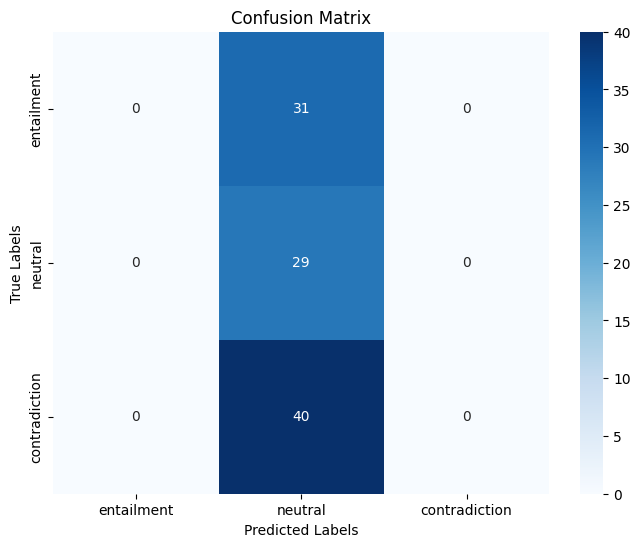

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predictions, labels=[0, 1, 2])
class_names = ['entailment', 'neutral', 'contradiction']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()